Share of contradictory tweets daily. Lower is 'less polarized discourse':
Tweets are measured against each other and analyzed with a model trained with SimpleRNN
on a Standord Natural Language Inference Dataset. 

*Notable events lead to lower polarization:*

* July 29 - 38.4%  --Olenivka prison attack
* August 9 - 43.2% --Crimea Russian base attack
* August 24 - 39.5% -- Ukraine Independence Day
* October 2 - 41.0% --Annexation of certain territories
* October 11 - 46.1% -- Russian terror attacks on Kyiv

Generally polarization seems to be trending down.



In [2]:
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, TimeDistributed, SimpleRNN, GlobalMaxPooling1D
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords


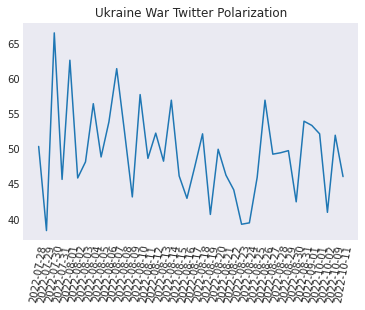

In [3]:
dates = ["2022-07-28", "2022-07-29", "2022-07-30", "2022-07-31", "2022-08-01", 
          "2022-08-02", "2022-08-03", "2022-08-04", "2022-08-05", "2022-08-06", 
         "2022-08-07", "2022-08-08", "2022-08-09", "2022-08-10", "2022-08-11", 
         "2022-08-12", "2022-08-13", "2022-08-14", "2022-08-15", "2022-08-16", 
         "2022-08-17", "2022-08-18", "2022-08-19", "2022-08-20", "2022-08-21",
         "2022-08-22","2022-08-23", "2022-08-24", "2022-08-25", "2022-08-26", "2022-08-27", 
         "2022-08-28", "2022-08-29","2022-08-30", "2022-08-31", "2022-09-01", "2022-10-01", "2022-10-02", "2022-10-09","2022-10-11"]

polarization = [50.4, 38.4, 66.6, 45.7, 62.7, 45.9,48.2,56.5,48.9,53.9,61.5,
                52.5,43.2,57.8,48.7,52.3,48.3,57.0,46.2,43.0,47.5,52.2,40.7,
                50.0,46.3,44.2, 39.3, 39.5, 46.0, 57.0, 49.3, 49.5, 49.8, 42.5, 54.0, 53.4, 52.2, 41.0, 52, 46.1]

plt.style.use('seaborn-dark')
plt.plot(dates, polarization)
plt.xticks(rotation=80)
plt.title("Ukraine War Twitter Polarization")

plt.show()

In [3]:
train_data = pd.read_csv("../input/stanford-natural-language-inference-corpus/snli_1.0_train.csv")
test_data = pd.read_csv("../input/stanford-natural-language-inference-corpus/snli_1.0_test.csv")
validation_data = pd.read_csv("../input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv")

train_data = train_data[:10000]
test_data = test_data[:10000]
validation_data = validation_data[:10000]

dataset = pd.concat([train_data, test_data, validation_data])

stop_words = stopwords.words('english')

In [4]:
dataset = dataset[['gold_label', 'sentence1', 'sentence2']]
dataset.dropna(axis=0, inplace=True) #removing missing values

In [5]:
dataset = dataset.loc[dataset['gold_label'] != "-"]
dataset = dataset.loc[dataset['gold_label'] != "neutral"]
dataset = dataset.sample(frac = 1)

sentence1 = dataset['sentence1']
sentence2 = dataset['sentence2']
label = dataset['gold_label']

In [6]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

sentence1 = CleanFeatures(sentence1)
sentence2 = CleanFeatures(sentence2)


In [7]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape 
all_sentences = all_sentences.reshape(-1,1 )
all_sentences = all_sentences.reshape(all_sentences.shape[0])


In [8]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(all_sentences)
sentence1_seq = tokenizer.texts_to_sequences(sentence1)
sentence1 = pad_sequences(sentence1_seq)

sentence2_seq = tokenizer.texts_to_sequences(sentence2)
sentence2 = pad_sequences(sentence2_seq, maxlen= sentence1.shape[1])

In [9]:
label_ = LabelEncoder()
labels = label_.fit_transform(label)
vocabulary = len(tokenizer.word_index)
labels = to_categorical(labels)



In [10]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape

(2, 19877, 34)

In [11]:
all_sentences = all_sentences.reshape(all_sentences.shape[1], 2, all_sentences.shape[2])
all_sentences.shape

(19877, 2, 34)

In [12]:
def glove_word_embedding(file_name, vocabulary):
  embeddings_index = {}
  file_ = open(file_name)
  for line in file_:
      arr = line.split()
      single_word = arr[0]
      w = np.asarray(arr[1:],dtype='float32')
      embeddings_index[single_word] = w
  file_.close()
  max_words = vocabulary + 1
  word_index = tokenizer.word_index
  embedding_matrix = np.zeros((max_words,50)).astype(object)
  for word , i in word_index.items():
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector 
  return embedding_matrix


In [13]:
model_rnn = tf.keras.models.Sequential()
model_rnn.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2],)))
model_rnn.add(tf.keras.layers.TimeDistributed(SimpleRNN(128, return_sequences=True)))
model_rnn.add(tf.keras.layers.Dropout(0.10))
model_rnn.add(tf.keras.layers.TimeDistributed(SimpleRNN(128, return_sequences=True)))
model_rnn.add(tf.keras.layers.Dropout(0.10))
model_rnn.add((tf.keras.layers.TimeDistributed(GlobalMaxPooling1D())))
model_rnn.add(tf.keras.layers.Flatten())
model_rnn.add(tf.keras.layers.Dense(2, activation='softmax'))
model_rnn.layers[0].set_weights([glove_word_embedding("../input/glove6b50dtxt/glove.6B.50d.txt", vocabulary)])
model_rnn.layers[0].trainable = False
model_rnn.summary()



2022-10-12 08:23:51.695326: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 34, 50)         447050    
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 34, 128)        22912     
_________________________________________________________________
dropout (Dropout)            (None, 2, 34, 128)        0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 34, 128)        32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 34, 128)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [14]:
model_rnn.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])



In [15]:
training = model_rnn.fit(all_sentences,labels,
                         epochs= 100,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                    )



Epoch 1/100


2022-10-12 08:23:57.840922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


20/20 [==============================] - 12s 454ms/step - loss: 0.7070 - accuracy: 0.4980
Epoch 2/100
20/20 [==============================] - 9s 453ms/step - loss: 0.6962 - accuracy: 0.5135
Epoch 3/100
20/20 [==============================] - 9s 449ms/step - loss: 0.6940 - accuracy: 0.5171
Epoch 4/100
20/20 [==============================] - 10s 493ms/step - loss: 0.6930 - accuracy: 0.5243
Epoch 5/100
20/20 [==============================] - 9s 447ms/step - loss: 0.6908 - accuracy: 0.5362
Epoch 6/100
20/20 [==============================] - 9s 454ms/step - loss: 0.6901 - accuracy: 0.5407
Epoch 7/100
20/20 [==============================] - 10s 504ms/step - loss: 0.6874 - accuracy: 0.5495
Epoch 8/100
20/20 [==============================] - 9s 462ms/step - loss: 0.6860 - accuracy: 0.5549
Epoch 9/100
20/20 [==============================] - 9s 455ms/step - loss: 0.6850 - accuracy: 0.5586
Epoch 10/100
20/20 [==============================] - 10s 495ms/step - loss: 0.6816 - accuracy: 0.56

In [16]:
#model_rnn.save('/content/drive/MyDrive/natural_language_inference/rnndistmodel')

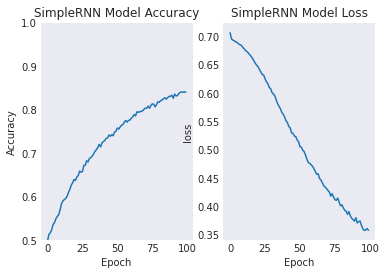

In [17]:
plt.style.use('seaborn-dark')

plt.subplot(1,2,1)
plt.plot(training.history['accuracy'], label='accuracy')
plt.title('SimpleRNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])

plt.subplot(1,2,2)
plt.plot(training.history['loss'])
plt.title('SimpleRNN Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [18]:
model_rnn.evaluate(all_sentences,labels, batch_size = 1024,use_multiprocessing=True, workers = -1)

20/20 [==============================] - 3s 141ms/step - loss: 0.2750 - accuracy: 0.9032


[0.27498769760131836, 0.9032046794891357]

In [19]:
y_pred = model_rnn.predict(all_sentences, batch_size=1024, verbose= 1)
y_pred = np.argmax(y_pred, axis = 1)

20/20 [==============================] - 3s 136ms/step


In [20]:
y_test = np.argmax(labels, axis = 1)
y_test.shape
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9032047089601046

In [21]:
ukr_tweets = pd.read_csv('../input/russia-vs-ukraine-tweets-datasetdaily-updated/filename.csv')
ukr_tweets.columns
tweets = ukr_tweets["tweet"]

In [22]:
def preprocess(sentence):
  texts = []
  pred_input = sentence
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  pred_input = [word for word in pred_input.split() if word not in stop_words]
  pred_input = ' '.join(pred_input)
  print(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],all_sentences.shape[2])
  return pred_input

In [23]:
def logical_link(sen1, sen2):
   randsent1 = preprocess(sen1)
   randsent2 = preprocess(sen2)
   full_input = np.asarray([randsent1, randsent2])
   full_input = full_input.reshape(1, 2, all_sentences.shape[2])
   y_predict = model_rnn.predict(full_input)
   y_pred = np.argmax(y_predict)
   class_name = ['contradiction', 'entailment']
   return class_name[y_pred]


In [24]:
def percentage_count(n):

  entailment_count = 0
  contradiction_count = 0

  for pred in range(n):
    if logical_link(tweets.sample(), tweets.sample()) == 'entailment':
      entailment_count += 1
    else:
      contradiction_count += 1
  
  percentage = 100 * float(contradiction_count)/float(n)

  return 'The percentage of contradictory statements is ' + str(percentage) + '%'

In [25]:
result = percentage_count(2000)
print(result)

@foscari1991 @ibligine @libero_official lui invaso per 2 motivi! 1. che nel 2014 hanno fatto la guerriglia nel dumbass e nessuno mai fatto trapelare la notizia... 2. che la nato si espande e la russia non vuole basi americane vicino hai suoi confini! lo ha detto putin stesso, nessuno lo ha ascoltato...
@apmassaro3 un needs dissolved russia problem whole organization shame. organization hypocrites backstabbers
@joncoopertweets reek russia😉
@steaderphil @hodgetwins @podcastsandpot read comments replying me. • single one condemns russia's genocidal invasion • single one expresses support ukraine's resistance invaded struck nerve. got answer. https://t.co/t8h5fiodny
@elonmusk @sawyermerritt don’t tell american people u tried buy 3 icbm’s russia spacex founded? got guilty conscious?
@smirnoff_sprite @foxnews @tulsigabbard oh russia russia russia again. omg people sound like children.
@aalshareefh @mvanhulten try focus use logic: companies currently business russia paying taxes government. s

In [26]:
print(result)
polarization.append(result)


The percentage of contradictory statements is 46.1%
